In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

Читаем данные из файла со значениями потребления энергии



In [3]:
files.upload()
!ls

Saving my_PJME_MW.csv to my_PJME_MW.csv
my_PJME_MW.csv	sample_data


In [10]:
df = pd.read_csv('my_PJME_MW.csv')


In [15]:
df.head()

,Date,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
0,2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
1,2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2,2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
3,2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
4,2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [44]:
data = df.iloc[120000:,2:]

In [45]:
data

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
120000,30212.0,2015,9,11,3,254,37,4,0,0,0,0
120001,27951.0,2015,9,11,3,254,37,4,1,0,0,0
120002,26455.0,2015,9,11,3,254,37,4,2,0,0,0
120003,25563.0,2015,9,11,3,254,37,4,3,0,0,0
120004,25057.0,2015,9,11,3,254,37,4,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
145369,44057.0,2018,8,2,3,214,31,3,20,0,0,0
145370,43256.0,2018,8,2,3,214,31,3,21,0,0,0
145371,41552.0,2018,8,2,3,214,31,3,22,0,0,0
145372,38500.0,2018,8,2,3,214,31,3,23,0,0,0


In [46]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [47]:
train_split = 21000
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)

In [48]:
# список признаков, по которым будем учить
channelIndexes = [0,2, 4, 5, 6, 7,8]

# длина теста
valLen = 100
# длина истории для работы
xLen = 5
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split - 1,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]



In [49]:
train_data.head(7)

,0,2,4,5,6,7,8
0,-0.087636,0.59065,0.325465,0.544515,0.556913,0.499411,-1.660530
1,-0.447973,0.59065,0.325465,0.544515,0.556913,0.499411,-1.516070
2,-0.686392,0.59065,0.325465,0.544515,0.556913,0.499411,-1.371610
3,-0.828550,0.59065,0.325465,0.544515,0.556913,0.499411,-1.227149
4,-0.909192,0.59065,0.325465,0.544515,0.556913,0.499411,-1.082689
5,-0.861221,0.59065,0.325465,0.544515,0.556913,0.499411,-0.938229
6,-0.614356,0.59065,0.325465,0.544515,0.556913,0.499411,-0.793768


In [50]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10


Выделяем части на обучение и проверку

In [51]:
start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(7)]].values
yTrain = data_f.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future

xVal = val_data.iloc[:x_end+1][[val_data.columns[i] for i in range(7)]].values
yVal = data_f.iloc[label_start:,0].values


In [52]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(20999, 7)
(20999,)
(4359, 7)
(4359,)


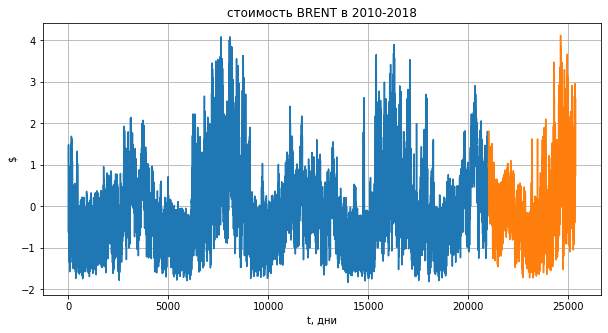

In [53]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+xLen+bias+future:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('стоимость BRENT в 2010-2018')
plt.show()

In [54]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)


In [55]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 5, 7)
Target shape: (32,)


In [56]:
inputs[2,:,0]

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([-0.18883671,  0.03061651,  0.17213754,  0.23827631,  0.24465113])>

In [57]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.244651126332399>

**сеть:  LSTM слои+Conv1D +Dense слой.**

Epoch 1/10
657/657 [==============================] - 7s 11ms/step - loss: 0.1653 - mae: 0.3131 - val_loss: 0.1194 - val_mae: 0.2727
Epoch 2/10
657/657 [==============================] - 6s 10ms/step - loss: 0.0764 - mae: 0.2126 - val_loss: 0.0797 - val_mae: 0.2189
Epoch 3/10
657/657 [==============================] - 6s 9ms/step - loss: 0.0417 - mae: 0.1571 - val_loss: 0.0874 - val_mae: 0.2307
Epoch 4/10
657/657 [==============================] - 7s 10ms/step - loss: 0.0348 - mae: 0.1433 - val_loss: 0.0603 - val_mae: 0.1916
Epoch 5/10
657/657 [==============================] - 7s 10ms/step - loss: 0.0297 - mae: 0.1317 - val_loss: 0.0474 - val_mae: 0.1712
Epoch 6/10
657/657 [==============================] - 6s 9ms/step - loss: 0.0261 - mae: 0.1229 - val_loss: 0.0508 - val_mae: 0.1759
Epoch 7/10
657/657 [==============================] - 6s 10ms/step - loss: 0.0241 - mae: 0.1183 - val_loss: 0.0489 - val_mae: 0.1719
Epoch 8/10
657/657 [==============================] - 6s 9ms/step - los

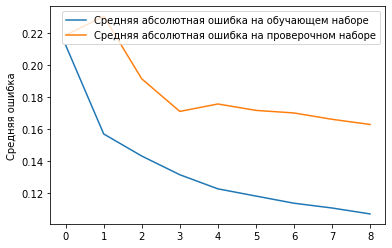

In [75]:
callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(32, return_sequences="True"))
model.add(Conv1D(128, 3, activation="linear"))
model.add(Conv1D(64, 3, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [71]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

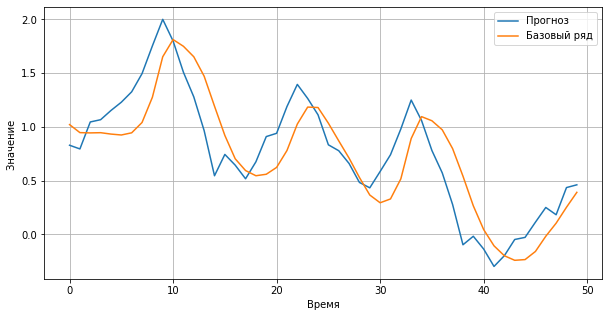

In [72]:
start = 0
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

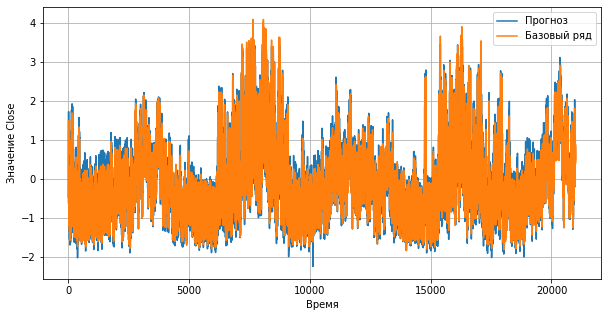

In [61]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели

In [73]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

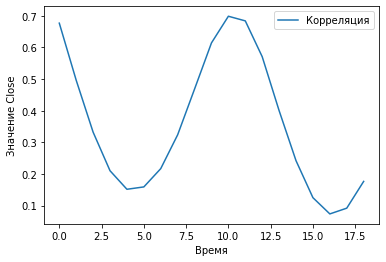

In [74]:
corr = []
start = 0
step = 50
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten()
yPredVal = predVal[h+start:start+step+h]
for i in range(1,20):
  corr.append(correlate(yValF[:-i], yPredVal[i:]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [64]:
corr

[0.7024755570284751,
 0.5327945336703155,
 0.3729958339372238,
 0.25310974951054555,
 0.19361253866785974,
 0.19749553880713536,
 0.25125599025069145,
 0.3532840953052946,
 0.49104716261053344,
 0.6249964859130833,
 0.6954786740040557,
 0.6735249003288951,
 0.5564118568735441,
 0.3841030131183628,
 0.22498347719805564,
 0.11090402740747407,
 0.06518610759386398,
 0.08688539374108664,
 0.17745361897242568]